In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D 
import spiceypy as spice

import math
# from datetime import datetime, timedelta

In [ ]:
spice.furnsh("./cassMetaK.txt")

step = 4000
# we are going to get positions between these two dates
utc = ['Jun 20, 2004', 'Dec 1, 2005'] # will iteratively need to be changed

# get et values one and two, we could vectorize str2et
etOne = spice.str2et(utc[0])
etTwo = spice.str2et(utc[1])
print("ET One: {}, ET Two: {}".format(etOne, etTwo))

# get times
times = [x*(etTwo-etOne)/step + etOne for x in range(step)]

# check first few times:
print(times[0:3])

#Run spkpos as a vectorized function
positions, lightTimes = spice.spkpos('Cassini', times, 'J2000', 'NONE', 'SATURN BARYCENTER')

# Positions is a 3xN vector of XYZ positions
print("Positions: ")
print(positions[0])

# Light times is a N vector of time
print("Light Times: ")
print(lightTimes[0])

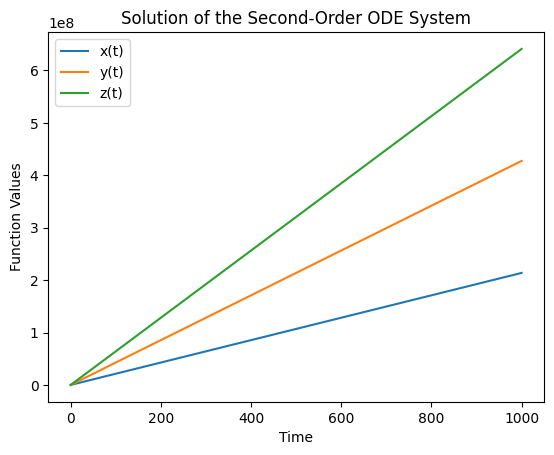

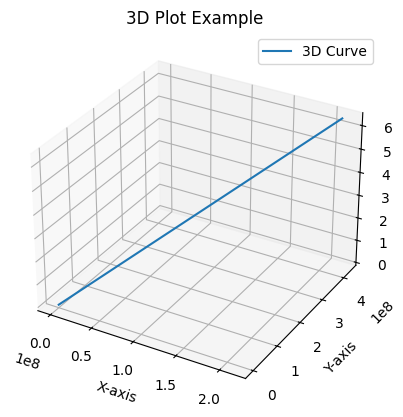

(100,)


In [25]:
# This function solves the non-linear problem, we need to use SPICE to completely define all the variables to this problem.
# This will require to also change the function a bit to make the args[] change with time

# This works, below is the trial version

# Define the second-order ODE system
def odefunc(t, r, r_moon_earth, r_moon_s_hat, r_earth_s_hat):
    G = 6.67430e-11
    mass_moon = 7.35e22
    mass_earth = 5.97e24
    dxdt = r[1]
    dydt = r[3]
    dzdt = r[5]
    distance_arr = np.array([r[0],r[2],r[4]])
    dx2dt2 = r_moon_s_hat[0]*G*mass_moon/(np.linalg.norm(distance_arr+r_moon_earth))**2 + r_earth_s_hat[0]*G*mass_earth/(np.linalg.norm(distance_arr))**2
    dy2dt2 = r_moon_s_hat[1]*G*mass_moon/(np.linalg.norm(distance_arr+r_moon_earth))**2 + r_earth_s_hat[1]*G*mass_earth/(np.linalg.norm(distance_arr))**2
    dz2dt2 = r_moon_s_hat[2]*G*mass_moon/(np.linalg.norm(distance_arr+r_moon_earth))**2 + r_earth_s_hat[2]*G*mass_earth/(np.linalg.norm(distance_arr))**2
    return [dxdt, dx2dt2, dydt, dy2dt2, dzdt, dz2dt2]


# Set the initial conditions
initial_state = np.array([6371, 0, 0, 0, 0, -0.047])  # x(0) = 1, dx/dt(0) = 0, y(0) = 2, dy/dt(0) = 0 ...

# Set the time span for integration
t_span = (0, 1000)

# trajectoryve the second-order ODE system using solve_ivp
r_moon_s_hat_earth = np.array([1,2,3])
r_moon_s_hat = np.array([1,2,3])
r_earth_s_hat = np.array([1,2,3])
sol = solve_ivp(odefunc, t_span, initial_state, args=(r_moon_s_hat_earth, r_moon_s_hat, r_earth_s_hat,), t_eval=np.linspace(t_span[0], t_span[1], 100))

# Plot the solutions for x and y
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[2], label='y(t)')
plt.plot(sol.t, sol.y[4], label='z(t)')
plt.title('Solution of the Second-Order ODE System')
plt.xlabel('Time')
plt.ylabel('Function Values')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[2], sol.y[4], label='3D Curve')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Plot Example')
ax.legend()
plt.show()

print(sol.y[0].shape)




In [17]:
# This function solves the non-linear problem, we need to use SPICE to completely define all the variables to this problem.
# This will require to also change the function a bit to make the args[] change with time


# Define the second-order ODE system
def odefunc(t, r, r_moon_earth):
    G = 6.67430e-11
    mass_moon = 7.35e22
    mass_earth = 5.97e24
    dxdt = r[1]
    dydt = r[3]
    dzdt = r[5]
    distance_arr = np.array([r[0],r[2],r[4]])
    r_hat = distance_arr/np.linalg.norm(distance_arr)
    r_moon_s_hat = (distance_arr + r_moon_earth)/np.linalg.norm(distance_arr + r_moon_earth)

    dx2dt2 = r_moon_s_hat[0]*G*mass_moon/(np.linalg.norm(distance_arr+r_moon_earth))**2 + r_hat[0]*G*mass_earth/(np.linalg.norm(distance_arr))**2
    dy2dt2 = r_moon_s_hat[1]*G*mass_moon/(np.linalg.norm(distance_arr+r_moon_earth))**2 + r_hat[1]*G*mass_earth/(np.linalg.norm(distance_arr))**2
    dz2dt2 = r_moon_s_hat[2]*G*mass_moon/(np.linalg.norm(distance_arr+r_moon_earth))**2 + r_hat[2]*G*mass_earth/(np.linalg.norm(distance_arr))**2
    return [dxdt, dx2dt2, dydt, dy2dt2, dzdt, dz2dt2]


time = np.arange(0,4000) # decide on time of integration

# ------------ find positions of the moon relative to earth for wanted times ------------ #
spice.furnsh("./cassMetaK.txt")

step = len(time)
# we are going to get positions between these two dates
utc = ['Jun 20, 2004', 'Dec 1, 2005'] # will iteratively need to be changed

# get et values one and two, we could vectorize str2et
etOne = spice.str2et(utc[0])
etTwo = spice.str2et(utc[1])

# get times
times = [x*(etTwo-etOne)/step + etOne for x in range(step)]

#Run spkpos as a vectorized function
positions, lightTimes = spice.spkpos('MOON', times, 'J2000', 'NONE', 'EARTH BARYCENTER')
# ------------ find positions of the moon relative to earth for wanted times ------------ #

# initiate array   
x = np.array([])
y = np.array([])
z = np.array([])

for i in range(len(time)-1):
    
    # Set the time span for integration
    t_span = (time[i],time[i+1])
    # Solve the second-order ODE system using solve_ivp
    # get this from naif !!!!!! work on tomorrow get it according to i

    #r_moon_earth = np.array(positions[i])
    r_moon_earth = positions[i]

    if i == 0:
        initial_state = np.array([6371, 0, 0, 0, 0, -0.047])  # x(0) = 1, dx/dt(0) = 0, y(0) = 2, dy/dt(0) = 0 ...
    else:
        initial_state = trajectory[i] # the previous solution
    
    sol = solve_ivp(odefunc, t_span, initial_state, args=(r_moon_earth,), t_eval=np.linspace(t_span[0], t_span[1], 100))
    x = np.append(x,sol.r[0])    
    y = np.append(y,sol.r[2])    
    z = np.append(z,sol.r[4])    



# # Plot the solutions for x and y
# plt.plot(trajectory.t, trajectory.r[0], label='x(t)')
# plt.plot(trajectory.t, trajectory.r[2], label='y(t)')
# plt.plot(trajectory.t, trajectory.r[4], label='z(t)')
# plt.title('Solution of the Second-Order ODE System')
# plt.xlabel('Time')
# plt.ylabel('Function Values')
# plt.legend()
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(trajectory.r[0], trajectory.r[2], trajectory.r[4], label='3D Curve')
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Z-axis')
# ax.set_title('3D Plot Example')
# ax.legend()
# plt.show()


TypeError: float() argument must be a string or a real number, not 'OdeResult'

In [34]:
r_moon_s_hat_earth = np.array([-1,2,3])
r_moon_s_hat_earth[1]

t_span = np.arange(0, 24*3600)
t_span[3]
t_eval=np.linspace(t_span[0], t_span[-1], 100)

initial_state = np.array([6371, 0, 0, 0, 0, -0.047]).T # x(0) = 1, dx/dt(0) = 0, y(0) = 2, dy/dt(0) = 0 ...
initial_state
dist = np.linalg.norm(r_moon_s_hat_earth-np.array([0,0,0]))
dist





a = np.array([[1,2],[3,4]])
print(a.shape)

b = np.array([])
print(b)

c = np.zeros(5)
b = np.append(b,c)

d = np.array([1,1])
b = np.append(b,d)
b

(2, 2)
[]


array([0., 0., 0., 0., 0., 1., 1.])